In [3]:
%matplotlib ipympl
import time
import json
import traceback
from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
from onix.units import ureg
from onix.helpers import present_float
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile
import allantools
from tqdm import tqdm
from uncertainties import ufloat, unumpy
from scipy.stats import pearsonr
from allantools import adev
from datetime import datetime

In [4]:
def data_identification_to_list(data_identification):
    if isinstance(data_identification, tuple):
        return range(data_identification[0], data_identification[1] + 1)
    elif isinstance(data_identification, int):
        return [data_identification]
    else:
        # it should be a list
        return data_identification

In [68]:
def get_average_heights(data_number):
    data, headers = get_experiment_data(data_number)

    detunings_MHz = headers["detunings"].to("MHz").magnitude
    transmissions_avg = group_and_average_data(data["transmissions_avg"], headers["params"]["detect"]["cycles"])
    monitors_avg = group_and_average_data(data["monitors_avg"], headers["params"]["detect"]["cycles"])
    
    plt_monitor = True
    use_positive = None
    
    antihole_avg = transmissions_avg["antihole"]
    rf_avg = transmissions_avg["rf"]
    if "chasm" in transmissions_avg:
        chasm_avg = transmissions_avg["chasm"]
        antihole_normalized = antihole_avg / chasm_avg
        rf_normalized = rf_avg / chasm_avg
    else:
        chasm_avg = None
        antihole_normalized = antihole_avg / monitors_avg["antihole"]
        rf_normalized = rf_avg / monitors_avg["rf"]
    if "lf" in transmissions_avg:
        lf_normalized = transmissions_avg["lf"] / monitors_avg["lf"]
    
    if headers["params"]["field_plate"]["use"]:
        if "use_opposite_field" not in headers["params"]["field_plate"]:
            hat_E = (headers["params"]["field_plate"]["amplitude"] > 0)
        else:
            hat_E = (headers["params"]["field_plate"]["amplitude"] > 0) == (not headers["params"]["field_plate"]["use_opposite_field"])
        hat_probe = headers["params"]["field_plate"]["stark_shift"] > 0
        mask = detunings_MHz > 0
        mask1 = detunings_MHz < 0
        if "lf" in transmissions_avg:
            return (np.array([np.average(antihole_normalized[mask]), np.average(antihole_normalized[mask1])]), 
            np.array([np.average(rf_normalized[mask]), np.average(rf_normalized[mask1])]), 
            np.array([np.average(lf_normalized[mask]), np.average(lf_normalized[mask1])]), headers, (hat_E, hat_probe))
        else:
            return (
                np.array([
                    np.average(antihole_normalized[mask]), np.average(antihole_normalized[mask1])
                ]),
                np.array([
                    np.average(rf_normalized[mask]), np.average(rf_normalized[mask1])
                ]),
                np.array([
                    np.std(antihole_normalized[mask]) / np.sqrt(len(antihole_normalized[mask])), np.std(antihole_normalized[mask1]) / np.sqrt(len(antihole_normalized[mask1]))
                ]),
                np.array([
                    np.std(rf_normalized[mask]) / np.sqrt(len(antihole_normalized[mask])), np.std(rf_normalized[mask1]) / np.sqrt(len(antihole_normalized[mask1]))
                ]),
                headers,
                (hat_E, hat_probe),
            )
            
    else:
        return np.average(antihole_normalized), np.average(rf_normalized), headers, None

def get_voltage_ratios(data_list):
    ratios = []
    ratios_err = []
    ratios2 = []
    headers = []
    E_fields = []
    # for kk in data_list:
    #     h1, h2, h3, header, E_field = get_average_heights(kk)
    #     ratios.append(h2 / h1)
    #     ratios2.append((h3-h2)/(h2-h1))
    #     headers.append(header)
    #     E_fields.append(E_field)
    # return np.array(ratios), np.array(ratios2), headers, E_fields
    for kk in data_list:
        h1, h2, h1_err, h2_err, header, E_field = get_average_heights(kk)
        ratios.append(h2 / h1)
        ratios_err.append(np.sqrt((h2_err / h1) ** 2 + (h1_err * h2 / h1**2) ** 2))
        headers.append(header)
        E_fields.append(E_field)
    return np.ones(len(ratios)), np.array(ratios), np.array(ratios_err), headers, E_fields

## Time-series Ramsey

In [4]:
def get_sine_fit(detunings, voltages, p0=None, bounds=None):
    def sine(f, f_0, t, a, c):
        return np.sin(2*np.pi*(f - f_0) * t) * a + c
    fitter = Fitter(sine)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    fitter.set_p0({"f_0": 0.001, "c": np.average(voltages), "t": 0.1, "a": (np.max(voltages) - np.min(voltages)) / 2})
    if p0 is not None:
        fitter.set_p0(p0)
    fitter.set_bounds("f_0", -1, 1)
    if bounds is not None:
        for bound_var, bound in bounds.items():
            fitter.set_bounds(bound_var, bound[0], bound[1])
    fitter.fit(maxfev = 10000)
    return fitter

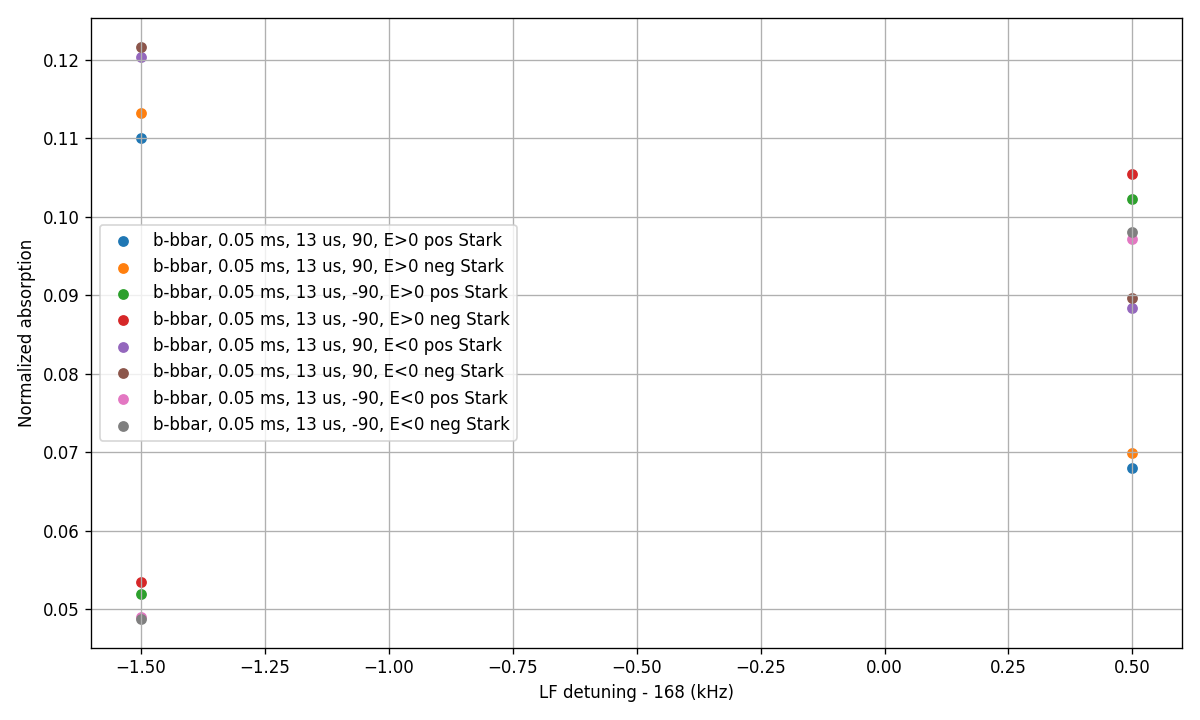

In [5]:
data = {
    # "b-bbar, 0.05 ms, 13 us, 90, E>0": (579736, 579755),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0": (579756, 579775),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0": (579776, 579795),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0": (579796, 579815),
    # "b-bbar, 0.05 ms, 13 us, 90, E>0, 1": (579816, 579835),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0, 1": (579836, 579855),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0, 1": (579856, 579875),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0, 1": (579876, 579895),
    # "b-bbar, 0.05 ms, 13 us, 90, E>0, 2": (580066, 580085),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0, 2": (580086, 580105),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0, 2": (580106, 580125),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0, 2": (580126, 580145),

    
    # "new params": (580680, 580699),
    # "new params 2": (580700, 580719),

    # "longer averaging": (580734, 580753),
    # "longer averaging 2": (580754, 580773),
    # "b-bbar, 0.05 ms, 13 us, 90, E>0": (581177, 581178),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0": (581179, 581180),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0": (581181, 581182),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0": (581183, 581184),
    # "b-bbar, 0.05 ms, 13 us, 90, E>0, 1": (581290, 581291),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0, 1": (581292, 581293),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0, 1": (581294, 581295),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0, 1": (581296, 581297),
    # "b-bbar, 0.05 ms, 13 us, 90, E>0, 2": (581830, 581831),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0, 2": (581832, 581833),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0, 2": (581834, 581835),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0, 2": (581836, 581837),
    # "b-bbar, 0.05 ms, 13 us, 90, E>0, 3": (582214, 582215),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0, 3": (582216, 582217),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0, 3": (582218, 582219),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0, 3": (582220, 582221),
}

# new sequence
data = {
    # "T pi/2 = 0.013 ms": (610325, 610334),
    # "T pi/2 = 0.0125 ms": (610553, 610560),
    # "T pi/2 = 0.0135 ms": (610563, 610572),
    # "T pi/2 = 0.014 ms": (610573, 610582),
    # "T pi/2 = 0.0145 ms": (610585, 610594),
    # "T C pi/2 = 0.0142 ms": (610613, 610622),
    # "T C pi/2 = 0.013 ms": (610633, 610642),
    # "T C pi/2 = 0.0132 ms": (610649, 610657),
    # "T pi/2 = 0.0145 ms repeat": (610658, 610667),
    # "0.5 wait time": (610725, 610734),
    # "0.5 wait time 2": (610735, 610744),
    # "0.5 wait time 3": (610745, 610754),
    # "0.5 wait time 4": (610755, 610764),
    # "4-pt-test2": (610686, 610687),
    # "0.3 ms": (610835, 610854),
    # "0.1 ms": (610860, 610864),
    # "0.05 ms": (610973, 610992),
    # "0.05 ms 2": (610993, 611012),
    # "1": (611244, 611249),
    # "2": (611250, 611255),
    # "3": (611256, 611261),
    # "4": (611065, 611066) 
    # "": (611325, 611334),
    # "2": (611335, 611344),
    # "rf_b, 50 us, 1": (612123, 612132),
    # "rf_b, 50 us, 2": (612133, 612142),
    # "rf_b, 50 us, 3": (612143, 612152),
    # "rf_b, 50 us, 4": (612153, 612162),
    # "rf_b, 100 us, 1": (612194, 612203),
    # "rf_b, 100 us, 2": (612204, 612213),
    # "rf_b, 100 us, 3": (612214, 612223),
    # "rf_b, 100 us, 4": (612224, 612233),
    "b-bbar, 0.05 ms, 13 us, 90, E>0": (612760, 612761),
    "b-bbar, 0.05 ms, 13 us, -90, E>0": (612762, 612763),
    "b-bbar, 0.05 ms, 13 us, 90, E<0": (612764, 612765),
    "b-bbar, 0.05 ms, 13 us, -90, E<0": (612766, 612767), #
}
plt_background = False

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios1, ratios2, headers, E_field = get_voltage_ratios(data_list)
    xs = [header["params"]["lf"]["detuning"].to("kHz").magnitude for header in headers]
    ys = (1-ratios1)
    y2s = 1-ratios2
    if E_field[0] is not None:
        if not plt_background:
            ax.scatter(xs, y2s[:,0], label=label + " pos Stark", s = 30)
            ax.scatter(xs, y2s[:,1], label=label + " neg Stark", s = 30)
        else:
            ax.scatter(xs, ys[:,0], label=label + "1 pos Stark", s = 30)
            ax.scatter(xs, ys[:,1], label=label + "1 neg Stark", s = 30)
            
        #ax.scatter(xs, ys[:,0], label=label + "1 pos Stark", s = 30)
        #ax.scatter(xs, y2s[:,0], label=label + " pos Stark", s = 30)
        # pos_fit = get_sine_fit(xs, y2s[:, 0]/ys[:,0])
        # ax.plot(xs, pos_fit.fitted_value(xs))
        #ax.scatter(xs, ys[:,1], label=label + "1 neg Stark", s = 30)
        #ax.scatter(xs, y2s[:,1], label=label + " neg Stark", s = 30)
        # neg_fit = get_sine_fit(xs, y2s[:, 1]/ys[:, 1])
        # ax.plot(xs, neg_fit.fitted_value(xs))

ax.set_xlabel(f"LF detuning - {headers[0]["params"]["lf"]["center_frequency"].to("kHz").magnitude} (kHz)")
ax.set_ylabel("Normalized absorption")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

In [252]:
data = {
    # "b-bbar, 0.05 ms, 13 us, 90, E>0": (579736, 579755),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0": (579756, 579775),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0": (579776, 579795),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0": (579796, 579815),
    
    # "b-bbar, 0.05 ms, 13 us, 90, E>0": (580066, 580085),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0": (580086, 580105),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0": (580106, 580125),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0": (580126, 580145),

    
    # "b-bbar, 0.05 ms, 13 us, 90, E>0": (580734, 580753),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0": (580754, 580773),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0": (580774, 580793),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0": (580794, 580813),


    # T_violation data 1 day
    # "b-bbar, 0.05 ms, 13 us, 90, E>0": (581218, 581219),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0": (581220, 581221),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0": (581222, 581223),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0": (581224, 581225), # 588206


    # T_violation data 1 day using 100X antihole repeats (~12 HOURS)
    # "b-bbar, 0.05 ms, 13 us, 90, E>0": (601009, 601010),  # 100 ah repeats, Jun 26 night
    # "b-bbar, 0.05 ms, 13 us, -90, E>0": (601011, 601012),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0": (601013, 601014),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0": (601015, 601016),  # 607440


    # # T_violation data 1 day using 400X of antihole repeats (~1 HOUR 20 MINUTES)
    # "b-bbar, 0.05 ms, 13 us, 90, E>0": (607483, 607484),  # 400 ah repeats, Jun 27 morning
    # "b-bbar, 0.05 ms, 13 us, -90, E>0": (607485, 607486),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0": (607487, 607488),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0": (607489, 607490), #607870

    
    # # T_violation data 1 day using 400X of antihole repeats, shorter antihole durations, 1 detection (**)
    # "b-bbar, 0.05 ms, 13 us, 90, E>0": (607874, 607875),  # 400 ah repeats, Jun 27 morning
    # "b-bbar, 0.05 ms, 13 us, -90, E>0": (607876, 607877),
    # "b-bbar, 0.05 ms, 13 us, 90, E<0": (607878, 607879),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0": (607880, 607881), #608297

    
    # T_violation data 1 day using 100x of antihole repeats, 100 h run
    # "b-bbar, 0.05 ms, 13 us, 90, E<0": (612760, 612761),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0": (612762, 612763),
    # "b-bbar, 0.05 ms, 13 us, 90, E>0": (612764, 612765),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0": (612766, 612767), # 647177

    # SAME AS ABOVE DATA BUT IGNORE FIRST 1000
    # T_violation data 1 day using 100x of antihole repeats, 100 h run
    # "b-bbar, 0.05 ms, 13 us, 90, E<0": (613760, 613761),
    # "b-bbar, 0.05 ms, 13 us, -90, E<0": (613762, 613763),
    # "b-bbar, 0.05 ms, 13 us, 90, E>0": (613764, 613765),
    # "b-bbar, 0.05 ms, 13 us, -90, E>0": (613766, 613767), # 647177

    # 65 us
    # "a-abar, 90, E>0, 65": (823027, 823028),
    # "a-abar, -90, E>0, 65": (823029, 823030),
    # "a-abar, 90, E<0, 65": (823031, 823032),
    # "a-abar, -90, E<0, 65": (823033, 823034),
    # "b-bbar, 90, E>0, 65": (823035, 823036),
    # "b-bbar, -90, E>0, 65": (823037, 823038),
    # "b-bbar, 90, E<0, 65": (823039, 823040),
    # "b-bbar, -90, E<0, 65": (823041, 823042),

    # 250 us
    # "a-abar, 90, E>0, 0.25, 0.25": (823621, 823622),  # 841716
    # "a-abar, -90, E>0, 0.25, 0.25": (823623, 823624),
    # "a-abar, 90, E<0, 0.25, 0.25": (823625, 823626),
    # "a-abar, -90, E<0, 0.25, 0.25": (823627, 823628),
    # "b-bbar, 90, E>0, 0.25, 0.25": (823629, 823630),
    # "b-bbar, -90, E>0, 0.25, 0.25": (823631, 823632),
    # "b-bbar, 90, E<0, 0.25, 0.25": (823633, 823634),
    # "b-bbar, -90, E<0, 0.25, 0.25": (823635, 823636),

    # 250 us, 6 MHz Stark
    # "a-abar, 90, E>0, 0.25, 0.25": (841761, 841762),
    # "a-abar, -90, E>0, 0.25, 0.25": (841763, 841764),
    # "a-abar, 90, E<0, 0.25, 0.25": (841765, 841766),
    # "a-abar, -90, E<0, 0.25, 0.25": (841767, 841768),  # 842784

    # # 250 us, 2 MHz Stark
    # "a-abar, 90, E>0, 0.25, 0.25": (842785, 842786),
    # "a-abar, -90, E>0, 0.25, 0.25": (842787, 842788),
    # "a-abar, 90, E<0, 0.25, 0.25": (842789, 842790),
    # "a-abar, -90, E<0, 0.25, 0.25": (842791, 842792),  # 843696

    # 50 us
    # "b-bbar, 90, E>0": (844818, 844819),  # 845193
    # "b-bbar, -90, E>0": (844820, 844821),
    # "b-bbar, 90, E<0": (844822, 844823),
    # "b-bbar, -90, E<0": (844824, 844825),

    # 50 us again
    "b-bbar, 90": (861853, 861854),
    "b-bbar, -90": (861855, 861856),
    
}
max = 862380

total_exp_time = (get_experiment_data(max)[1]["data_info"]["save_epoch_time"] - get_experiment_data(data[list(data)[0]][0])[1]["data_info"]["save_epoch_time"])/3600

fs = {}
f1 = []
f2 = []
Es = []

for kk in data:
    fs[kk] = []

all_results = []

current = data[list(data.keys())[-1]][1]
offset = 0
while current + offset <= max:
    for ll, (label, data_range) in enumerate(data.items()):
        if ll % 2 == 1:
            continue
        data_range_1 = (data_range[0] + offset, data_range[1] + offset)
        data_list1 = data_identification_to_list(data_range_1)
        ratios_bg, ratios, headers, E_field_1 = get_voltage_ratios(data_list1)
        xs = [header["params"]["lf"]["detuning"].to("kHz").magnitude for header in headers]
        ys = (1-ratios)
        data_range_2 = (data_range[0] + offset + 2, data_range[1] + offset + 2)
        data_list2 = data_identification_to_list(data_range_2)
        ratios_bg, ratios, headers, E_field_2 = get_voltage_ratios(data_list2)
        y1s = (1-ratios)
        if E_field_1 != E_field_2:
            raise Exception("Must use data for the same E field")

        xs = (np.array(xs) + headers[0]["params"]["lf"]["center_frequency"].to("kHz").magnitude) * 1000
        xs_diff = xs[1] - xs[0]
        for kk in range(2):
            ys_red_diff = ys[0][kk] - y1s[0][kk]
            ys_blue_diff = y1s[1][kk] - ys[1][kk]
            x_center = xs_diff * ys_red_diff / (ys_red_diff + ys_blue_diff) + xs[0]
            neg_DdotE = kk == 0
            E = E_field_1[0][0]
            D = (not neg_DdotE) == E
            detect_order = E_field_1[0][1]
            data_indices = list(data_list1) + list(data_list2)
            epoch_times = (
                get_experiment_data(data_range_1[0])[1]["start_time"],
                get_experiment_data(data_range_2[-1])[1]["data_info"]["save_epoch_time"],
            )
            all_results.append(
                {
                    "freq_center": x_center,
                    "E": E,
                    "D": D,
                    "detect_red_first": detect_order,
                    "data_indices": data_indices,
                    "epoch_times": epoch_times,
                }
            )
            
    offset += 2 * 2

f1 = np.array(f1)
f2 = np.array(f2)

In [369]:
# if input(f"Create new analysis folder? (y/n) ") == "y":
#     analysis_folder_index = open_analysis_folder("lf_spectroscopy")
# else:
#     analysis_folder_index = int(input("Enter analysis number: "))
# print("Current analysis number: ", analysis_folder_index)

In [370]:
# if input(f"Save in analysis #{analysis_folder_index}? (y/n) ") == "y":
#     with open(get_analysis_file_path(analysis_folder_index, "all_data.json"), "w") as f:
#         json.dump(all_results, f)

In [375]:
def uniform_averaging(average_time, *args):
    """Averages times and frequencies data, and samples them at the same times.
    
    Args can be any number of pairs of times and freqs.
    """
    all_data = {}
    for kk in range(len(args) // 2):
        all_data[f"d{kk}"] = np.array([args[kk * 2], args[kk * 2 + 1]])
    min_time = 0
    max_time = np.inf
    for kk in all_data:
        dataset_min_time = np.min(all_data[kk][0])
        dataset_max_time = np.max(all_data[kk][0])
        if dataset_max_time < max_time:
            max_time = dataset_max_time
        if dataset_min_time > min_time:
            min_time = dataset_min_time
    sample_times = np.arange(min_time + average_time / 2, max_time - average_time / 2, average_time)
    frequencies_sampled = {}
    for kk in all_data:
        frequencies = []
        for sample_time in sample_times:
            mask = (all_data[kk][0] >= sample_time - average_time / 2) & (all_data[kk][0] < sample_time + average_time / 2)
            frequencies.append(np.average(all_data[kk][1][mask]))
        frequencies_sampled[kk] = np.array(frequencies)
    return tuple([sample_times] + list(frequencies_sampled.values()))

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

average_time = 50

## Ramsey time series

In [70]:
data_range = (612760, 612763)
max = 620000
first = data_range[0]
last = max

all_results = []

current = data_range[-1]
offset = 0
while current + offset <= max:
    data_range_1 = (data_range[0] + offset, data_range[1] + offset)
    data_list1 = data_identification_to_list(data_range_1)
    ratios_bg, ratios, ratios_err, headers, E_field = get_voltage_ratios(data_list1)
    if E_field.count(E_field[0]) != len(E_field):
        raise Exception("Data with different E or detect order")
    detunings = [header["params"]["lf"]["detuning"].to("Hz").magnitude for header in headers]
    phases = [header["params"]["lf"]["phase_diff"] for header in headers]
    ys = (1-ratios)
    ys_err = ratios_err

    detunings = np.array(detunings) + headers[0]["params"]["lf"]["center_frequency"].to("Hz").magnitude
    detuning_diff = np.max(detunings) - np.min(detunings)
    negative_detuning_mask = detunings == np.min(detunings)
    positive_detuning_mask = detunings == np.max(detunings)
    if np.min(detunings) == np.max(detunings):
        raise Exception("Data only has one detuning")
    negative_phase_mask = phases == np.min(phases)
    positive_phase_mask = phases == np.max(phases)
    if np.min(phases) == np.max(phases):
        raise Exception("Data only has one phase")
    for kk in range(2):
        ys_red_diff = ys[negative_detuning_mask & positive_phase_mask][0][kk] - ys[negative_detuning_mask & negative_phase_mask][0][kk]
        ys_red_diff_err = np.sqrt(ys_err[negative_detuning_mask & positive_phase_mask][0][0]**2 + ys_err[negative_detuning_mask & negative_phase_mask][0][0]**2)
        ys_red_diff = ufloat(ys_red_diff, ys_red_diff_err)
        ys_blue_diff = ys[positive_detuning_mask & negative_phase_mask][0][kk] - ys[positive_detuning_mask & positive_phase_mask][0][kk]
        ys_blue_diff_err = np.sqrt(ys_err[positive_detuning_mask & negative_phase_mask][0][0]**2 + ys_err[positive_detuning_mask & positive_phase_mask][0][0]**2)
        ys_blue_diff = ufloat(ys_blue_diff, ys_blue_diff_err)
        freq_center = detuning_diff * ys_red_diff / (ys_red_diff + ys_blue_diff) + detunings[0]
        freq_center_err = freq_center.std_dev
        freq_center = freq_center.n
        neg_DdotE = kk == 0
        E = E_field[0][0]
        D = (not neg_DdotE) == E
        detect_order = E_field[0][1]
        data_indices = list(data_list1)
        epoch_times = (
            get_experiment_data(data_range_1[0])[1]["data_info"]["save_epoch_time"],
            get_experiment_data(data_range_1[-1])[1]["data_info"]["save_epoch_time"],
        )
        all_results.append(
            {
                "freq_center": freq_center,
                "freq_center_err": freq_center_err,
                "E": E,
                "D": D,
                "detect_red_first": detect_order,
                "data_indices": data_indices,
                "start_time": epoch_times[0],
                "end_time": epoch_times[1],
            }
        )
            
    offset += len(data_list1)

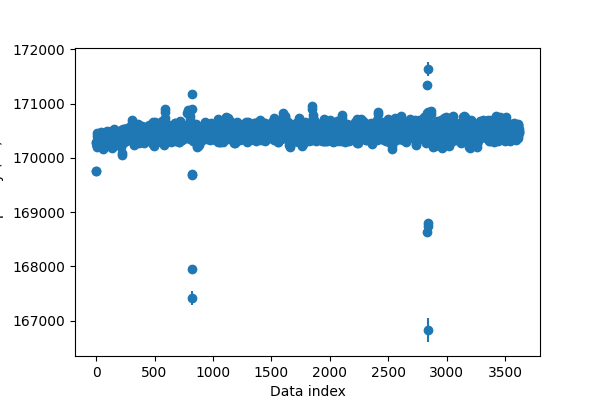

In [71]:
fs = [result["freq_center"] for result in all_results]
fs_err = [result["freq_center_err"] for result in all_results]

fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(np.arange(len(fs)), fs, fs_err, fmt="o", ls="none")


ax.set_xlabel("Data index")
ax.set_ylabel("$b\\bar{b}$ frequency (Hz)")
plt.show()

In [72]:
all_results = np.array(all_results)
all_mask = np.ones(len(all_results), dtype=bool)
unlock_mask = np.ones(len(all_results), dtype=bool)
D_p1_mask = np.ones(len(all_results), dtype=bool)
D_m1_mask = np.ones(len(all_results), dtype=bool)
E_p1_mask = np.ones(len(all_results), dtype=bool)
E_m1_mask = np.ones(len(all_results), dtype=bool)
a_mask = np.ones(len(all_results), dtype=bool)
b_mask = np.ones(len(all_results), dtype=bool)
for kk, value in enumerate(all_results):
    # for unlock_time in unlock_times:
    #     if value["epoch_times"][0] - 2 < unlock_time and unlock_time < value["epoch_times"][1]:
    #         unlock_mask[kk] = False
    #         break
    if value["freq_center"] > 200000:
        b_mask[kk] = False
    else:
        a_mask[kk] = False
    if value["D"]:
        D_p1_mask[kk] = True
        D_m1_mask[kk] = False
    else:
        D_p1_mask[kk] = False
        D_m1_mask[kk] = True
    if value["E"]:
        E_p1_mask[kk] = True
        E_m1_mask[kk] = False
    else:
        E_p1_mask[kk] = False
        E_m1_mask[kk] = True
start_mask = np.ones(len(all_results), dtype=bool)
for kk in range(10):
    start_mask[kk] = False

In [64]:
import pandas
all_combined_results = {}
for kk in all_results[0]:
    all_combined_results[kk] = [result[kk] for result in all_results]
pandas.DataFrame.from_dict(all_combined_results).to_csv("July_8_comagnetometer.csv")

In [65]:
with open("July_8_comagnetometer.csv", "r") as f:
    all_results = pandas.read_csv(f)

-0.09964876490376808 1.484610414483134


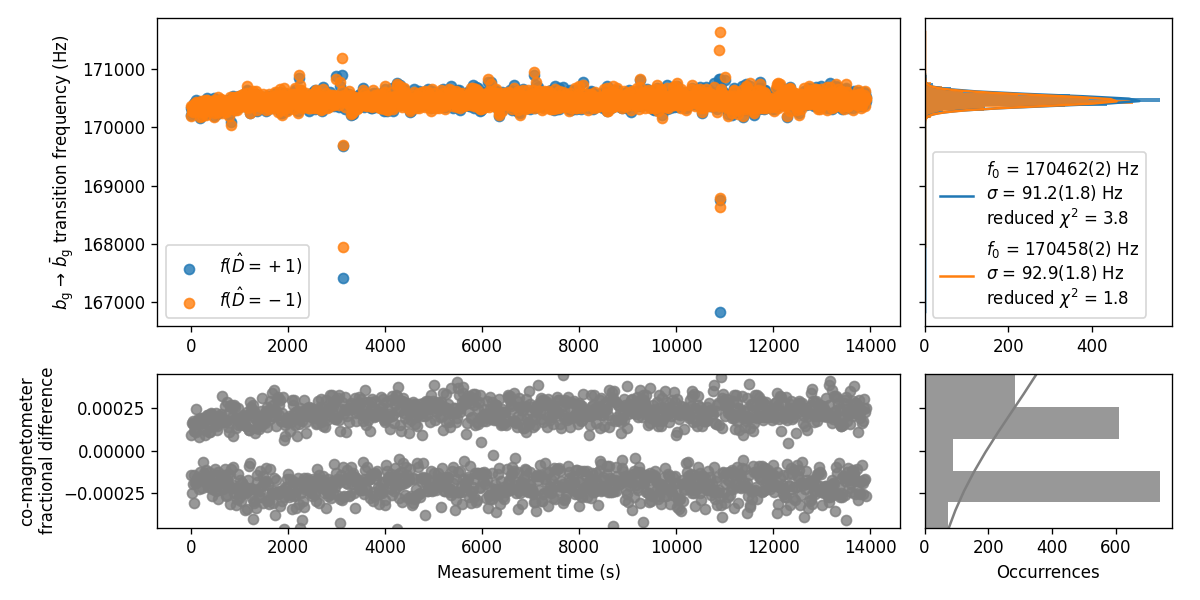

In [75]:
def gaussian(f, f0, sigma, a, c):
    return a * np.exp(-(f-f0)**2 / (2 * sigma**2)) + c

def gaussian_fitter_histogram(xs, hists):
    xs = xs[1:] - (xs[1] - xs[0]) / 2
    nonzero_hist_mask = hists != 0
    fitter = Fitter(gaussian)
    fitter.set_nicknames({"f0": "$f_0$", "sigma": "$\\sigma$", "a": "$a$", "c": "$c$"})
    fitter.set_units({"f0": "Hz", "sigma": "Hz"})
    fitter.set_data(xs[nonzero_hist_mask], hists[nonzero_hist_mask], np.sqrt(hists[nonzero_hist_mask]))
    fitter.set_p0({"f0": np.average(xs, weights=hists), "sigma": np.std(xs), "a": np.max(hists) - np.min(hists), "c": np.min(hists)})
    return fitter
    
fig, axs = plt.subplots(2, 2, figsize = (10, 5), dpi = 120, sharey="row", gridspec_kw={"width_ratios": [3, 1], "height_ratios": [2, 1]})
n_bins = int(np.sqrt(len(all_results)))
bins_alpha = 0.8

for kk, D_mask in enumerate([D_p1_mask, D_m1_mask]):
    mask = unlock_mask & start_mask & b_mask & D_mask
    fs = np.array([result["freq_center"] for result in all_results[mask]])
    ts = np.array([result["start_time"] for result in all_results[mask]])
    ts -= ts[0]

    if kk == 0:
        label = "$f(\\hat{D} = +1)$"
    else:
        label = "$f(\\hat{D} = -1)$"
    axs[0][0].scatter(ts, fs, label=label, alpha=bins_alpha)
    axs[0][1].hist(fs, bins=n_bins, orientation="horizontal", alpha=bins_alpha)
   
    hists, xs = np.histogram(fs, bins=n_bins)
    fitter = gaussian_fitter_histogram(xs, hists)
    fitter.fit()
    label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
    xs_plt = np.linspace(np.min(fs), np.max(fs), 100)
    axs[0][1].plot(fitter.fitted_value(xs_plt), xs_plt, color=f"C{kk}", label=label)

mask1 = unlock_mask & start_mask & b_mask & D_p1_mask
mask2 = unlock_mask & start_mask & b_mask & D_m1_mask
fs = np.array([result["freq_center"] for result in all_results[mask1]]) - np.array([result["freq_center"] for result in all_results[mask2]])
avg_f = (np.array([result["freq_center"] for result in all_results[mask1]]) + np.array([result["freq_center"] for result in all_results[mask2]])) / 2

label = "$f(\\hat{D} = +1) - f(\\hat{D} = -1)$"
axs[1][0].scatter(ts, fs / avg_f, label=label, alpha=bins_alpha, color="C7")
axs[1][1].hist(fs / avg_f, bins=n_bins, orientation="horizontal", alpha=bins_alpha, color="C7")
print(np.average(fs), np.std(fs) / np.sqrt(len(fs / avg_f)))

hists, xs = np.histogram(fs / avg_f, bins=n_bins)
fitter = gaussian_fitter_histogram(xs, hists)
fitter.fit()
label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
xs_plt = np.linspace(np.min(fs / avg_f), np.max(fs / avg_f), 100)
axs[1][1].plot(fitter.fitted_value(xs_plt), xs_plt, color=f"C7", label=label)

axs[1][0].set_xlabel("Measurement time (s)")
axs[0][0].set_ylabel("$b_\mathrm{g}\ \\to\ \\bar{b}_\mathrm{g}$ transition frequency (Hz)")
axs[1][0].set_ylabel("co-magnetometer\nfractional difference")
axs[0][0].legend()
axs[1][1].set_xlabel("Occurrences")
axs[0][1].legend()
axs[1][0].set_ylim(-0.00045, 0.00045)
plt.tight_layout()
plt.show()

8(6) Hz


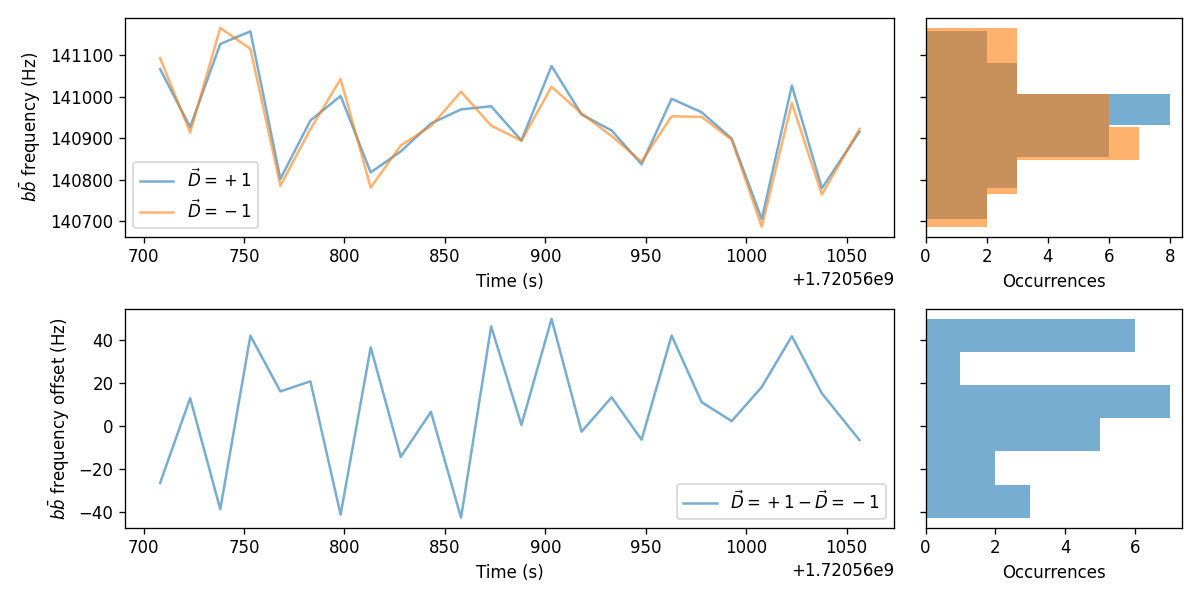

In [961]:
fig, axs = plt.subplots(2, 2, figsize = (10, 5), dpi = 120, sharey="row", gridspec_kw={"width_ratios": [3, 1]})
n_bins = int(np.sqrt(len(all_results)))
bins_alpha = 0.6

for kk, D_mask in enumerate([D_p1_mask, D_m1_mask]):
    mask = unlock_mask & start_mask & b_mask & D_mask
    fs = np.array([result["freq_center"] for result in all_results[mask]])
    ts = np.array([result["epoch_times"][0] for result in all_results[mask]])

    if kk == 0:
        label = "$\\vec{D} = +1$"
    else:
        label = "$\\vec{D} = -1$"
    axs[0][0].plot(ts, fs, label=label, alpha=bins_alpha)
    axs[0][1].hist(fs, bins=n_bins, orientation="horizontal", alpha=bins_alpha)
    
    hists, xs = np.histogram(fs, bins=n_bins)
    # fitter = gaussian_fitter_histogram(xs, hists)
    # fitter.fit()
    # label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
    # axs[0][1].plot(fitter.fitted_value(xs), xs, color=f"C{kk}", label=label)
    
axs[0][0].set_xlabel("Time (s)")
axs[0][0].set_ylabel("$b\\bar{b}$ frequency (Hz)")
axs[0][0].legend()
axs[0][1].set_xlabel("Occurrences")


mask1 = unlock_mask & start_mask & b_mask & D_p1_mask
mask2 = unlock_mask & start_mask & b_mask & D_m1_mask
fs = np.array([result["freq_center"] for result in all_results[mask1]]) - np.array([result["freq_center"] for result in all_results[mask2]])
ts = np.array([result["epoch_times"][0] for result in all_results[mask1]])

label = "$\\vec{D} = +1 - \\vec{D} = -1$"
axs[1][0].plot(ts, fs, label=label, alpha=bins_alpha)
axs[1][1].hist(fs, bins=n_bins, orientation="horizontal", alpha=bins_alpha)

fs_avg = np.average(fs)
fs_ste = np.std(fs) / np.sqrt(len(fs))
fs_str = present_float(fs_avg, fs_ste)
print(fs_str, "Hz")

hists, xs = np.histogram(fs, bins=n_bins)
# fitter = gaussian_fitter_histogram(xs, hists)
# fitter.fit()
# label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
# axs[1][1].plot(fitter.fitted_value(xs), xs, color=f"C0", label=label)
    
axs[1][0].set_xlabel("Time (s)")
axs[1][0].set_ylabel("$b\\bar{b}$ frequency offset (Hz)")
axs[1][0].legend()
axs[1][1].set_xlabel("Occurrences")

plt.tight_layout()
plt.show()

-30(30) Hz


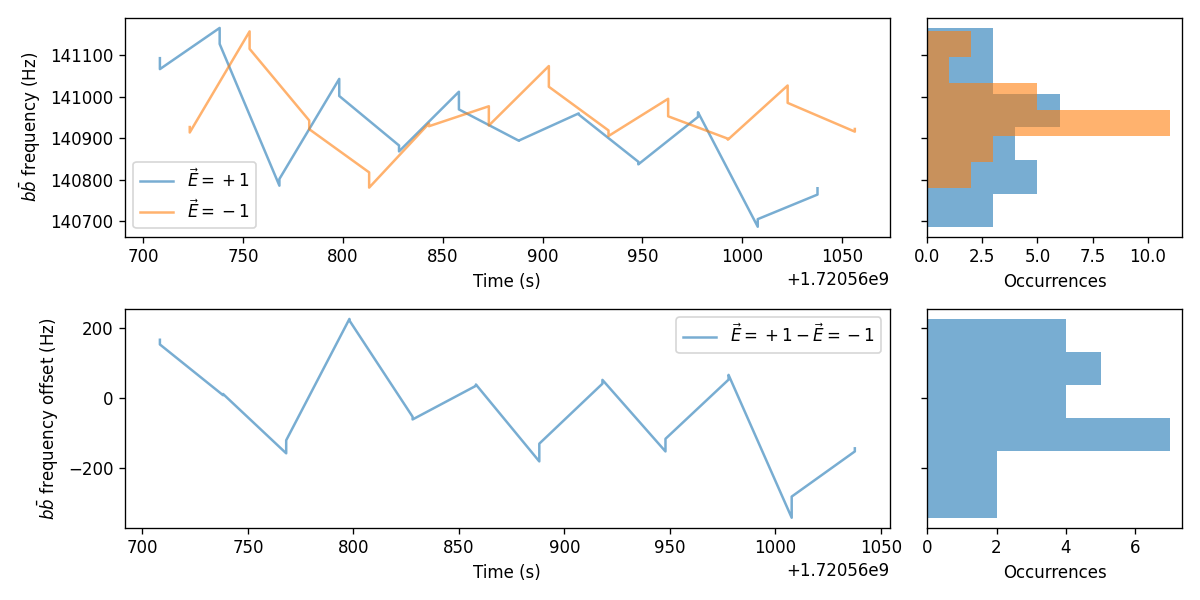

In [962]:
fig, axs = plt.subplots(2, 2, figsize = (10, 5), dpi = 120, sharey="row", gridspec_kw={"width_ratios": [3, 1]})
n_bins = int(np.sqrt(len(all_results)))
bins_alpha = 0.6

for kk, E_mask in enumerate([E_p1_mask, E_m1_mask]):
    mask = unlock_mask & start_mask & b_mask & E_mask
    fs = np.array([result["freq_center"] for result in all_results[mask]])
    ts = np.array([result["epoch_times"][0] for result in all_results[mask]])

    if kk == 0:
        label = "$\\vec{E} = +1$"
    else:
        label = "$\\vec{E} = -1$"
    axs[0][0].plot(ts, fs, label=label, alpha=bins_alpha)
    axs[0][1].hist(fs, bins=n_bins, orientation="horizontal", alpha=bins_alpha)
    
    hists, xs = np.histogram(fs, bins=n_bins)
    # fitter = gaussian_fitter_histogram(xs, hists)
    # fitter.fit()
    # label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
    # axs[0][1].plot(fitter.fitted_value(xs), xs, color=f"C{kk}", label=label)
    
axs[0][0].set_xlabel("Time (s)")
axs[0][0].set_ylabel("$b\\bar{b}$ frequency (Hz)")
axs[0][0].legend()
axs[0][1].set_xlabel("Occurrences")


mask1 = unlock_mask & start_mask & b_mask & E_p1_mask
mask2 = unlock_mask & start_mask & b_mask & E_m1_mask
fs = np.array([result["freq_center"] for result in all_results[mask1]]) - np.array([result["freq_center"] for result in all_results[mask2]])
ts = np.array([result["epoch_times"][0] for result in all_results[mask1]])

label = "$\\vec{E} = +1 - \\vec{E} = -1$"
axs[1][0].plot(ts, fs, label=label, alpha=bins_alpha)
axs[1][1].hist(fs, bins=n_bins, orientation="horizontal", alpha=bins_alpha)

fs_avg = np.average(fs)
fs_ste = np.std(fs) / np.sqrt(len(fs))
fs_str = present_float(fs_avg, fs_ste)
print(fs_str, "Hz")

hists, xs = np.histogram(fs, bins=n_bins)
# fitter = gaussian_fitter_histogram(xs, hists)
# fitter.fit()
# label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
# axs[1][1].plot(fitter.fitted_value(xs), xs, color=f"C0", label=label)
    
axs[1][0].set_xlabel("Time (s)")
axs[1][0].set_ylabel("$b\\bar{b}$ frequency offset (Hz)")
axs[1][0].legend()
axs[1][1].set_xlabel("Occurrences")

plt.tight_layout()
plt.show()

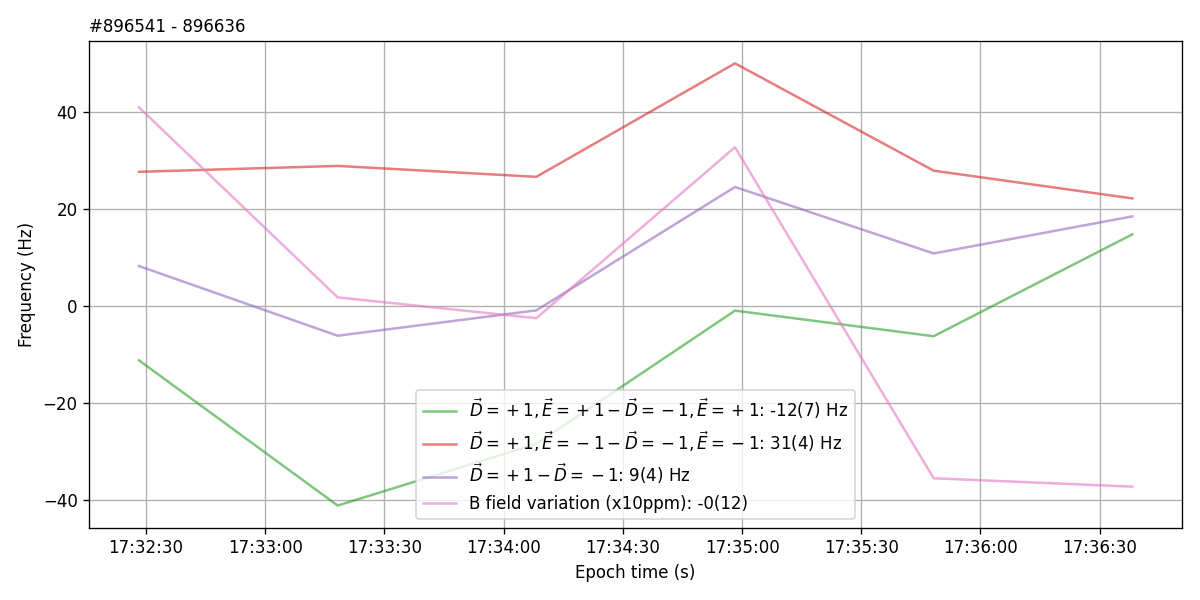

In [963]:
# fig, ax = plt.subplots(figsize = (10, 5), dpi = 120)
n_bins = int(np.sqrt(len(all_results))) * 2
bins_alpha = 0.6

data = []
for ll, D_mask in enumerate([D_p1_mask, D_m1_mask]):
    for kk, E_mask in enumerate([E_p1_mask, E_m1_mask]):
        mask = unlock_mask & start_mask & b_mask & D_mask & E_mask
        data.append([result["epoch_times"][0] for result in all_results[mask]])
        data.append([result["freq_center"] for result in all_results[mask]])
sample_times, D_p1_E_p1, D_p1_E_m1, D_m1_E_p1, D_m1_E_m1 = uniform_averaging(average_time, *tuple(data))

# for kk, data in enumerate([D_p1_E_p1, D_p1_E_m1, D_m1_E_p1, D_m1_E_m1]):
#     if kk < 2:
#         label = "$\\vec{D} = +1, "
#     else:
#         label = "$\\vec{D} = -1, "
#     if kk % 2 == 0:
#         label += "\\vec{E} = +1$"
#     else:
#         label += "\\vec{E} = -1$"
#     ts = sample_times
#     fs = data
    
#     ts_plt = [datetime.fromtimestamp(t) for t in ts]
#     ax.plot(ts_plt, fs, alpha=bins_alpha, label=label, color=f"C{kk}",)
    
# ax.set_xlabel("Toronto time")
# ax.set_ylabel("Time-binned $b\\bar{b}$ frequency (Hz)")
# ax.legend()
# plt.tight_layout()
# plt.show()

fig, ax = plt.subplots(figsize = (10, 5), dpi = 120)
n_bins = int(np.sqrt(len(all_results))) * 2
bins_alpha = 0.6

D_p1_E_p1_D_p1_E_m1 = D_p1_E_p1 - D_p1_E_m1
D_m1_E_p1_D_m1_E_m1 = D_m1_E_p1 - D_m1_E_m1

D_p1_E_p1_D_m1_E_p1 = D_p1_E_p1 - D_m1_E_p1
D_p1_E_m1_D_m1_E_m1 = D_p1_E_m1 - D_m1_E_m1

D_p1_D_m1 = ((D_p1_E_p1 + D_p1_E_m1) - (D_m1_E_p1 + D_m1_E_m1)) / 2
E_p1_E_m1 = ((D_p1_E_p1 + D_m1_E_p1) - (D_p1_E_m1 + D_m1_E_m1)) / 2

all = (D_p1_E_p1 + D_p1_E_m1 + D_m1_E_p1 + D_m1_E_m1) / 4
all = ((all / np.average(all)) - 1) * 1e5

for kk, data in enumerate([D_p1_E_p1_D_p1_E_m1, D_m1_E_p1_D_m1_E_m1, D_p1_E_p1_D_m1_E_p1, D_p1_E_m1_D_m1_E_m1, D_p1_D_m1, E_p1_E_m1, all]):
    if kk == 0:
        label = "$\\vec{D} = +1, \\vec{E} = +1 - \\vec{D} = +1, \\vec{E} = -1$"
        continue
    if kk == 1:
        label = "$\\vec{D} = -1, \\vec{E} = +1 - \\vec{D} = -1, \\vec{E} = -1$"
        continue
    if kk == 2:
        label = "$\\vec{D} = +1, \\vec{E} = +1 - \\vec{D} = -1, \\vec{E} = +1$"
    if kk == 3:
        label = "$\\vec{D} = +1, \\vec{E} = -1 - \\vec{D} = -1, \\vec{E} = -1$"
    if kk == 4:
        label = "$\\vec{D} = +1 - \\vec{D} = -1$"
    if kk == 5:
        label = "$\\vec{E} = +1 - \\vec{E} = -1$"
        continue
    if kk == 6:
        label = "B field variation (x10ppm)"
    ts = sample_times
    fs = data
    
    ts_plt = [datetime.fromtimestamp(t) for t in ts]
    fs_avg = np.average(fs)
    fs_ste = np.std(fs) / np.sqrt(len(fs))
    fs_str = present_float(fs_avg, fs_ste)
    if kk != 6:
        fs_str += " Hz"
    ax.plot(ts_plt, fs, alpha=bins_alpha, label=label + f": {fs_str}", color=f"C{kk}")

ax.text(0, 1.02, f"#{first} - {last}", transform=ax.transAxes)
ax.set_xlabel("Epoch time (s)")
ax.set_ylabel("Frequency (Hz)")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

## Fluctuations in LF Ramsey (1 data point)

KeyError: 'use_opposite_field'

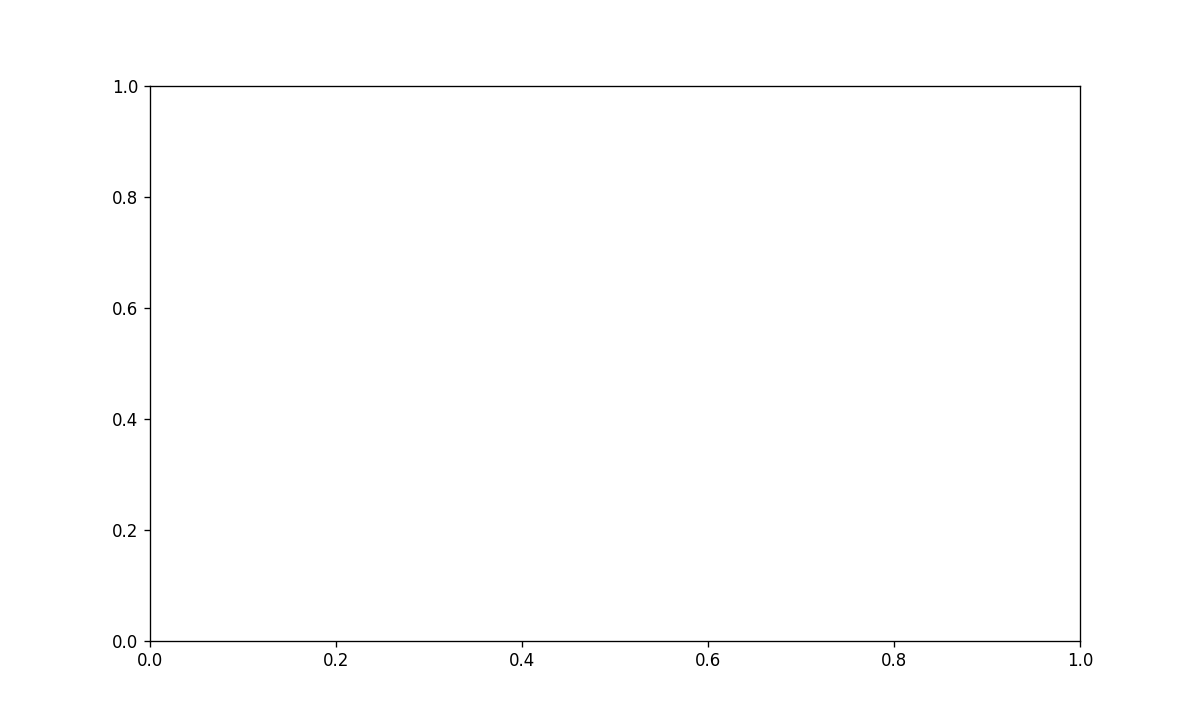

In [709]:
data = {
    # "original": (588222, 588418),
    # "sync 0.713(0.01)s": (592518, 592702),
    # "no sync": (592704, 592916),
    # "sync 0.713(0.001)s": (592923, 593092),
    # "no sync 2": (593094, 593306),
    # "no sync 3": (593328, 593553),


    # COMPARISON:    
    # "350 ao 32 detects": (594308, 594529),
    # "350 ao 64 detects": (594531, 594752),
    # "350 ao 256 detects": (594754, 594972),
    # "400 ao 64 detects": (594974, 595192),
    # "425 ao 64 detects": (595417, 595638),
    # "450 ao 64 detects": (595194, 595415),
    # "400 ao 64 detects rep": (595640, 595863),
    # "350 ao 64 detects rep": (595865, 596088),


    "350 ao 64 detects long data": (596089, 599091),
    # "350 ao 64 detects long data (SAME BUT IGNORE FIRST 1000)": (597089, 599091),
}
fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios, headers, E_field = get_voltage_ratios(data_list)
    # xs = [header["data_info"]["save_epoch_time"]-headers[0]["data_info"]["save_epoch_time"] for header in headers]
    xs = [i for i in range(len(headers))]
    ys = (1-ratios)
    if E_field[0] is not None:
        ax.scatter(xs, ys[:,0], label=label + " pos Stark", s = 30)
        ax.scatter(xs, ys[:,1], label=label + " neg Stark", s = 30)
        # ax.scatter(xs, ys[:,0]-ys[:,1], label=label + "$\\vec{D}=+1$ - $\\vec{D}=-1$", s = 30)

ax.set_xlabel(f"Save time (s)")
ax.set_ylabel("Normalized absorption")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

fig = plt.figure(figsize = (10, 8), dpi = 120)
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios, headers, E_field = get_voltage_ratios(data_list)
    xsys = (1-ratios)
    xs = xsys[:, 0]
    ys = xsys[:, 1]
    bins = 50
    ax.scatter(xs, ys, s = 30, alpha=0.7, label = f"{label}: $R$ = {pearsonr(xs, ys).statistic:.4f}")
    ax_histx.hist(xs, bins=bins, alpha=0.7, label=f"$\\mu/\\sigma$ = {np.average(xs)/np.std(xs):.4f}")
    ax_histy.hist(ys, bins=bins, alpha=0.7, orientation='horizontal', label=f"$\\mu/\\sigma$ = {np.average(ys)/np.std(ys):.4f}")

ax.set_xlabel("Normalized absorption $\\vec{D}=+1$")
ax.set_ylabel("Normalized absorption $\\vec{D}=-1$")
ax_histx.set_ylabel("Count")
ax_histy.set_xlabel("Count")
ax.grid()
ax.legend()
ax_histx.legend()
ax_histy.legend()
plt.show()



## Fluctuations in Hole burning

0.004199764272051945
0.006971096344848625
0.003937793905072617
0.0034490014055966814


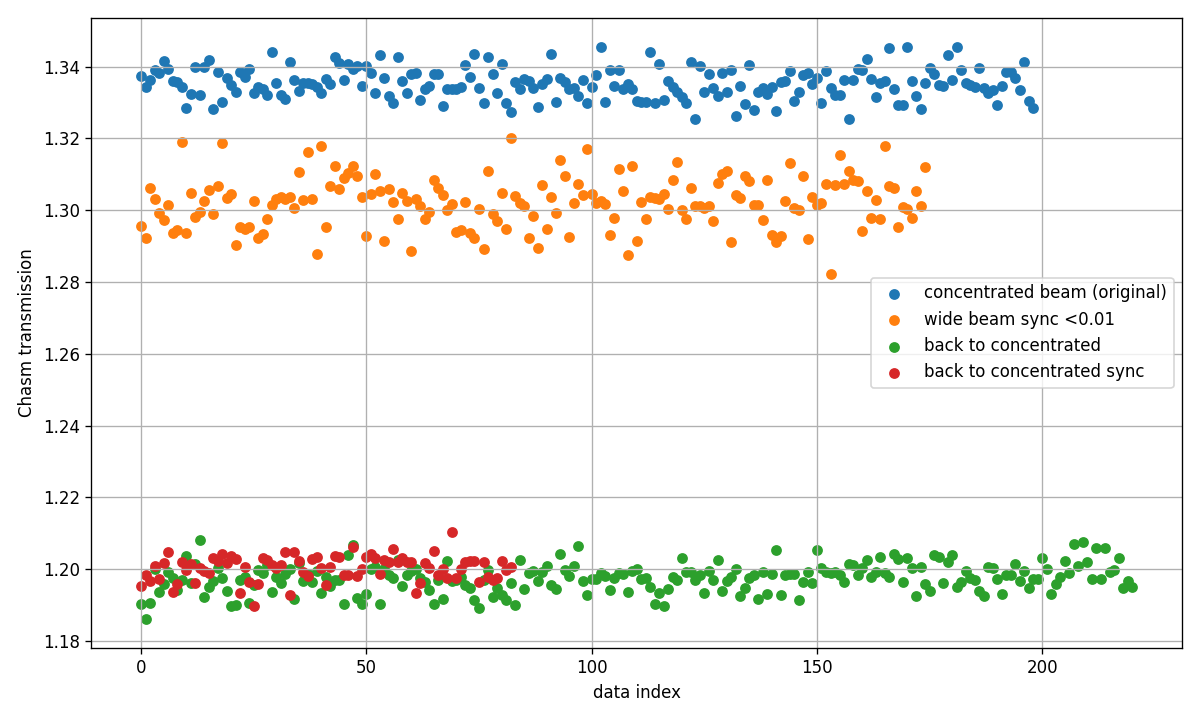

In [159]:
data = {
    # "chasm -> immediate detect": (588421, 588753)

    # chasm -> immediate detect -> wait -> detect
    "concentrated beam (original)": (589333, 589531),
    # "3 decimal sync": (590121, 590239),
    # "wider beam diameter": (590407, 591294),
    # "back to concentrated beam 2": (591568, 591693),
    # "wide beam 2": (591916, 592043),
    # "wide beam sync <0.1": (592090, 592150),
    "wide beam sync <0.01": (592271, 592445),
    "back to concentrated": (593659, 593879),
    "back to concentrated sync": (593891, 593973),
}
fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ys = []
    xs = []
    for kk, data_num in enumerate(data_list):
        transmissions_avg, monitors_avg, headers = averaged_data_from_number(data_num)
        # xs.append(headers["data_info"]["save_epoch_time"])
        xs.append(kk)
        ys.append((transmissions_avg["antihole"][0]/monitors_avg["antihole"][0]))
    print(np.std(ys))
    ax.scatter(xs, ys, s = 30, label=label)

ax.set_xlabel(f"data index")
ax.set_ylabel("Chasm transmission")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

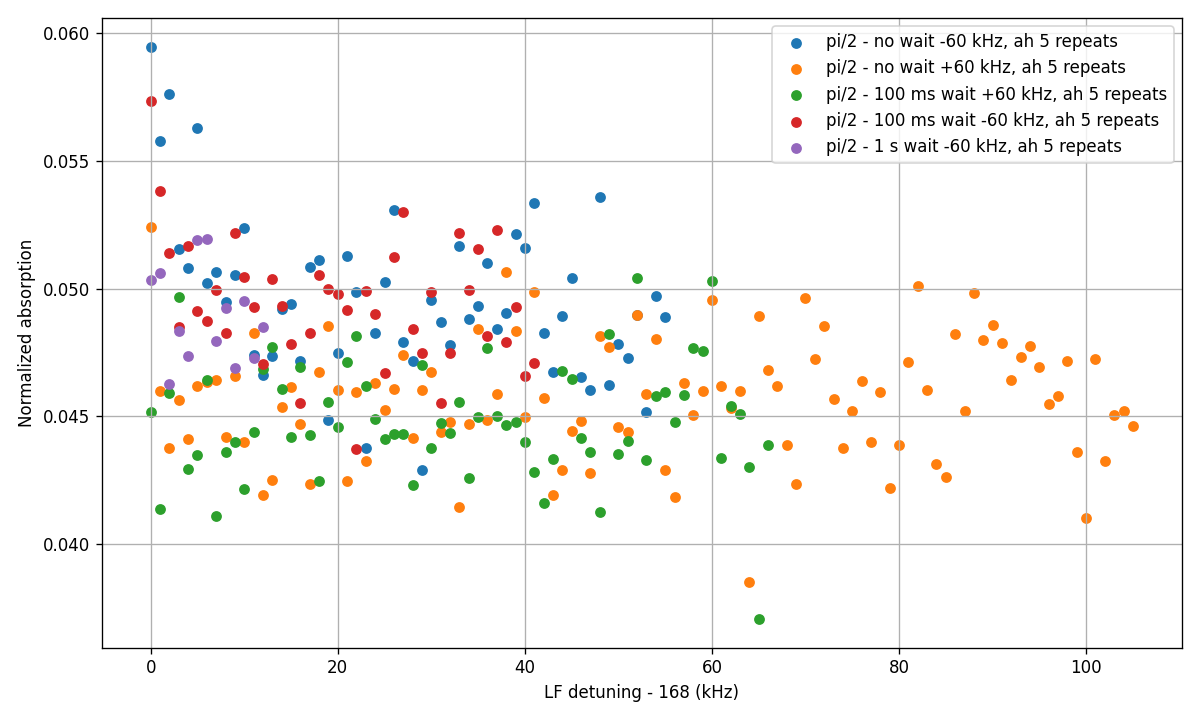

In [274]:
data = {
    # "pi/2 - no wait -60 kHz": (609490, 609544),
    # "pi/2 - no wait +60 kHz": (609545, 609591),
    # "pi/2 - no wait no rf": (609603, 609647),
    # "rf_b +60 kHz": (609649, 609707),
    # "rf_b -60 kHz": (609709, 609741),
    # "pi/2 - no wait +60 kHz, ah 20 repeats": (609743, 609826),
    # "pi/2 - no wait -60 kHz, ah 20 repeats": (609828, 609930),
    "pi/2 - no wait -60 kHz, ah 5 repeats": (609932, 609987),
    "pi/2 - no wait +60 kHz, ah 5 repeats": (609989, 610094),
    "pi/2 - 100 ms wait +60 kHz, ah 5 repeats": (610097, 610163),
    "pi/2 - 100 ms wait -60 kHz, ah 5 repeats": (610176, 610217),
    "pi/2 - 1 s wait -60 kHz, ah 5 repeats": (610249, 610261),
}

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios, headers, E_field = get_voltage_ratios(data_list)
    xs = [header["data_info"]["data_number"] for header in headers]
    xs = np.array(xs) - xs[0]
    ys = (1-ratios)[:, 0]
    ax.scatter(xs, ys, label=label, s = 30)

ax.set_xlabel(f"LF detuning - {headers[0]["params"]["lf"]["center_frequency"].to("kHz").magnitude} (kHz)")
ax.set_ylabel("Normalized absorption")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()